In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from find_walking_frames import find_walking_data
from pre_process import pull_acceleration

In [118]:
directory = 'data/'

subject_num = '5'

sub_5_walks = find_walking_data(subject_num, directory)

sub_5_walks.keys()

dict_keys(['05_05', '05_06', '05_07', '05_08', '05_09', '05_10', '05_11', '05_12', '05_13', '05_14', '05_19', '05_20'])

In [119]:
df = sub_5_walks['05_06'][0]

In [120]:
df.head()

,acc_rf_x,acc_rf_y,acc_rf_z,gyro_rf_x,gyro_rf_y,gyro_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,gyro_rs_x,...,gyro_ls_z,acc_lt_x,acc_lt_y,acc_lt_z,gyro_lt_x,gyro_lt_y,gyro_lt_z,EMG_r,EMG_l,act
171,-11040,-4052,11712,693,431,637,-16072,2120,-1632,-4050,...,9,-17024,1704,-1056,26,-110,120,128,129,1
172,-11172,-3996,11732,666,430,568,-15964,2144,-1800,-4602,...,3,-15824,1248,-24,33,-197,87,129,124,1
173,-11116,-3556,11824,595,283,453,-15536,2472,-1884,-3268,...,25,-16264,1392,-400,-98,-138,142,129,146,1
174,-11140,-3552,11780,547,299,144,-15908,1668,-2236,-1059,...,35,-15856,1264,-664,-228,-46,86,129,139,1
175,-11256,-3816,11652,393,87,54,-15640,1920,-2340,976,...,45,-15888,768,-952,-240,-20,-22,129,126,1


In [121]:
df.columns

Index(['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
       'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
       'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
       'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
       'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
       'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
       'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
       'gyro_lt_z', 'EMG_r', 'EMG_l', 'act'],
      dtype='object')

In [122]:
from datetime import timedelta

def conv_acceleration(num):
    return 2*num/32768


df_accel = pd.DataFrame(None)

for column in df.columns:
    if 'acc' in column:
        df_accel[column] = df[column].apply(conv_acceleration)

# delta = timedelta(seconds = 1/56.35)


# df_accel['time'] = (df.index - df.index[0]) * delta

# df_accel.set_index('time', inplace = True)

df_accel.head()

,acc_rf_x,acc_rf_y,acc_rf_z,acc_rs_x,acc_rs_y,acc_rs_z,acc_rt_x,acc_rt_y,acc_rt_z,acc_lf_x,acc_lf_y,acc_lf_z,acc_ls_x,acc_ls_y,acc_ls_z,acc_lt_x,acc_lt_y,acc_lt_z
171,-0.673828,-0.247314,0.714844,-0.980957,0.129395,-0.099609,-0.992188,0.080566,-0.093750,-0.617920,0.444824,0.639160,-0.908691,0.303223,-0.321289,-1.039062,0.104004,-0.064453
172,-0.681885,-0.243896,0.716064,-0.974365,0.130859,-0.109863,-0.974121,0.081543,-0.119629,-0.617432,0.447754,0.630371,-0.931152,0.288574,-0.363281,-0.965820,0.076172,-0.001465
173,-0.678467,-0.217041,0.721680,-0.948242,0.150879,-0.114990,-0.957520,0.056641,-0.129883,-0.628418,0.453369,0.625732,-0.899902,0.249023,-0.364258,-0.992676,0.084961,-0.024414
174,-0.679932,-0.216797,0.718994,-0.970947,0.101807,-0.136475,-0.973145,0.033691,-0.159668,-0.627686,0.426025,0.630615,-0.883789,0.257812,-0.372070,-0.967773,0.077148,-0.040527
175,-0.687012,-0.232910,0.711182,-0.954590,0.117188,-0.142822,-0.959961,0.031738,-0.141602,-0.625732,0.429688,0.629639,-0.908203,0.277832,-0.420410,-0.969727,0.046875,-0.058105


The acceleration data can be converted to gravitational accelleration by taking $2x/32768$.

In [123]:
df_accel_rs = df_accel[['acc_rs_x', 'acc_rs_y', 'acc_rs_z']]

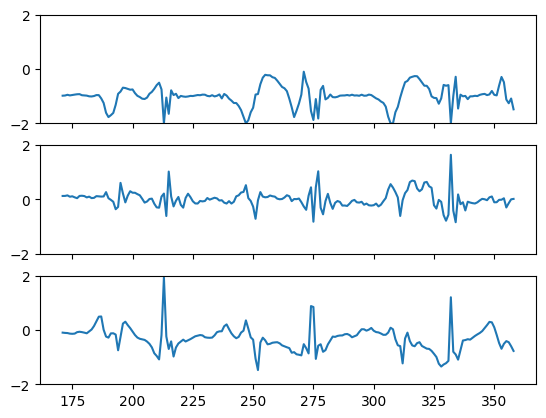

In [124]:
fig, axes = plt.subplots(3,1, sharex = True)
for ax,column in zip(axes, df_accel_rs.columns):
    ax.plot(df_accel_rs.index, df_accel_rs[column])
    ax.set_ylim(-2,2)

(-2.0, 2.0)

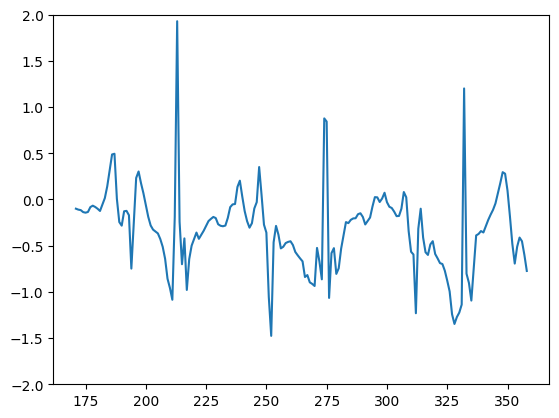

In [125]:
fig, ax = plt.subplots()
ax.plot(df_accel_rs.index, df_accel_rs['acc_rs_z'])
ax.set_ylim(-2,2)

[-9.19321772e-02 -8.35397897e-02 -5.33966276e-02 -9.39021562e-02
 -1.46672712e-01 -1.76104795e-01 -1.83015186e-01 -1.49746508e-01
 -9.60802469e-02 -5.70664423e-02 -6.69753733e-02 -8.36614481e-02
 -1.34808956e-01 -1.70677870e-01 -1.08927495e-01  1.72435894e-03
  4.87469968e-02  6.09350065e-02  3.76061947e-02  3.42412452e-02
  5.04768565e-02  8.03487788e-02  1.03349310e-01  1.31067629e-01
  1.43972573e-01  1.30370009e-01  1.17186311e-01  8.58544622e-02
  5.18627173e-02  6.48638336e-02  5.62771454e-02  2.59325709e-02
  1.60338520e-01  2.40003160e-01  1.50287614e-01  1.55253967e-01
  2.75936699e-01  2.37125121e-01  5.97443157e-02  1.42397438e-02
  6.75939287e-04 -1.93977742e-02 -2.89940685e-03  1.23998492e-02
  1.48636560e-02  8.48448295e-03  5.49658993e-04 -2.61004239e-04
  2.28011366e-03  1.19649876e-02] Figure(640x480)


61

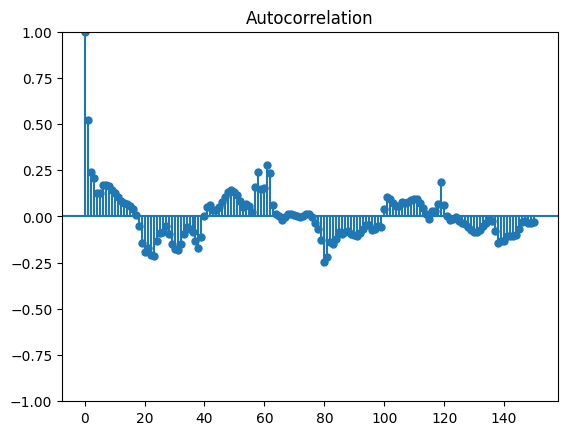

In [200]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
df = df_accel_rs['acc_rs_z']

autocorr = acf(df, nlags = 150)
print(
    autocorr[25:75],
    plot_acf(df, lags = 150, alpha = 1)
)

autocorr[25:70].argmax()
# The list reindexes so the argmax for this interval is really 25 + argmax
36 + 25

In [168]:
np.argmax(autocorr(df))

187

In [ ]:
from gtda.time_series import takens_embedding_optimal_parameters

max_embed_dim = 10
max_delay = 2
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    series, max_delay, max_embed_dim, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")


Optimal embedding time delay based on mutual information: 2
Optimal embedding dimension based on false nearest neighbors: 4


In [ ]:
from gtda.time_series import SingleTakensEmbedding

TE = SingleTakensEmbedding(time_delay=optimal_time_delay, dimension=optimal_embedding_dimension, stride=stride)
series_embedded = TE.fit_transform((series.reshape(-1,1)))

In [ ]:
from gtda.plotting import plot_point_cloud
plot_point_cloud(series_embedded)

In [ ]:
series_embedded_data = np.array(series_embedded)


In [ ]:
from gtda.homology import WeakAlphaPersistence

homology_dims = [0, 1]

WA = WeakAlphaPersistence(homology_dimensions = homology_dims)
X_diagrams = WA.fit_transform(series_embedded_data[None,:,:]) 
WA.plot(X_diagrams)